# Intro to Uber Movement Data


**Authors:** Alex Michels and Jinwoo Park

This notebook provides a brief overview of Uber Movement Data, demonstrates how to obtain and work with it, and illustrates a few examples of how to utilize the data for geospatial analysis.

![Map of NYC traffic speed as a percentage of free flow](img/nyc-pct_from_freeflow.png)

In [1]:
# a few parameters/variables
FIGSIZE=(18, 12)

In [2]:
# import a few useful python packages
import contextily as cx
import geopandas as gpd
import pandas as pd
import matplotlib.pyplot as plt
import momepy
import osmnx as ox
import networkx as nx
import math
import numpy as np
from tqdm import tqdm
import requests
from shapely.geometry import Polygon, MultiPolygon
from shapely.errors import ShapelyDeprecationWarning
import warnings
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning)  # ignore some deprecation warnings from shapely
warnings.filterwarnings("ignore", category=UserWarning)  # ignore a contextily warning

# Table of Contents

* [Overview](#overview)
* [Obtaining Uber Movement Data](#obtain)
    * [Web Interface](#obtain-web)
    * [Command Line Interface (CLI)](#obtain-cli)
* [Uber Movement for Travel Time Calcuation](#problem)
* [Obtaining OpenStreetMap Data](#osm)
    * [Typical way using OSMnx](#typical-osmnx)
    * [Historical OSM data from OSM Planet](#historical-osm)
* [Preprocessing Road Network](#preprocessing)
* [Using Uber Movement Data](#using)
    * [Match based on the start and end node IDs ](#approach-1)
    * [Match with Edge ID and Azimuth of edges](#approach-2)
* [Learn More / References](#ref)

<hr id="overview" />

# Overview

[Uber Movement](https://movement.uber.com/) provides access to aggregated data on travel-times, speeds, and mobility heatmaps which have been generously made available by Uber. This data is very valuable to researchers because travel-time data can be very costly to acquire. First, let's break down the three main types of data available:

* **Travel-Times:** This measures average travel-time (by day and time of day) between "traffic analysis zones" or neighborhoods, depending on the city. [Click here for an example in London](https://movement.uber.com/explore/london/travel-times).
* **Speeds:** This measures the speed as a percentage of free-flow travel-time on each segment of the road. [Click here for an example in New York City](https://movement.uber.com/explore/new_york/speeds).
* **Mobility Heatmap:** This is a newer feature showing traffic density within a city. [Click here for an example in Madrid](https://movement.uber.com/explore/madrid/mobility-heatmap).



<hr id="obtain" />

# Obtaining Uber Movement Data

While the web interface is beautiful, we need to obtain the data and combine it with other data for many of our analysis and modeling use-cases. There are two main ways to obtain the data: through the web interface and using the CLI created by Uber.

<p id="obtain-web" />

## Web Interface

The web interface provides a convenient and easy way to obtain data. 

First, let's visit the Uber Movement page in another tab: https://movement.uber.com/

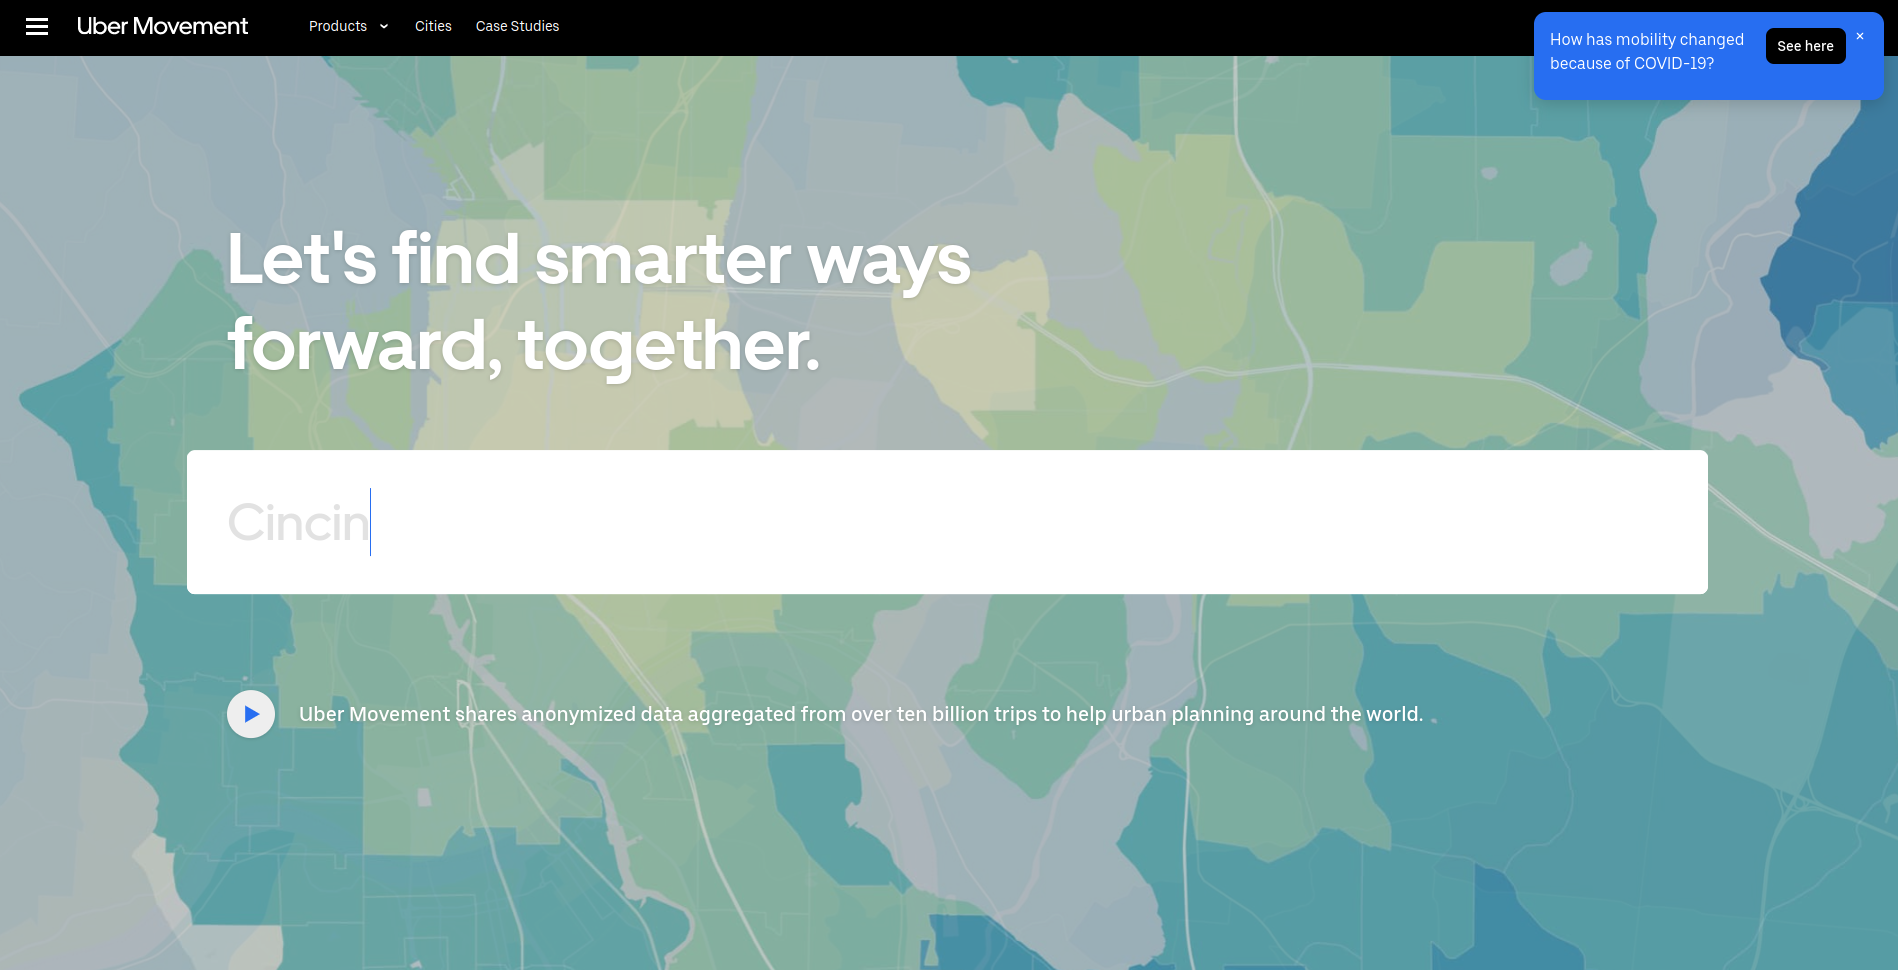

Mouse over "Products" in the top-left corner to view the three types of data products. Let's first select "Travel Times." You should see a screen like this:

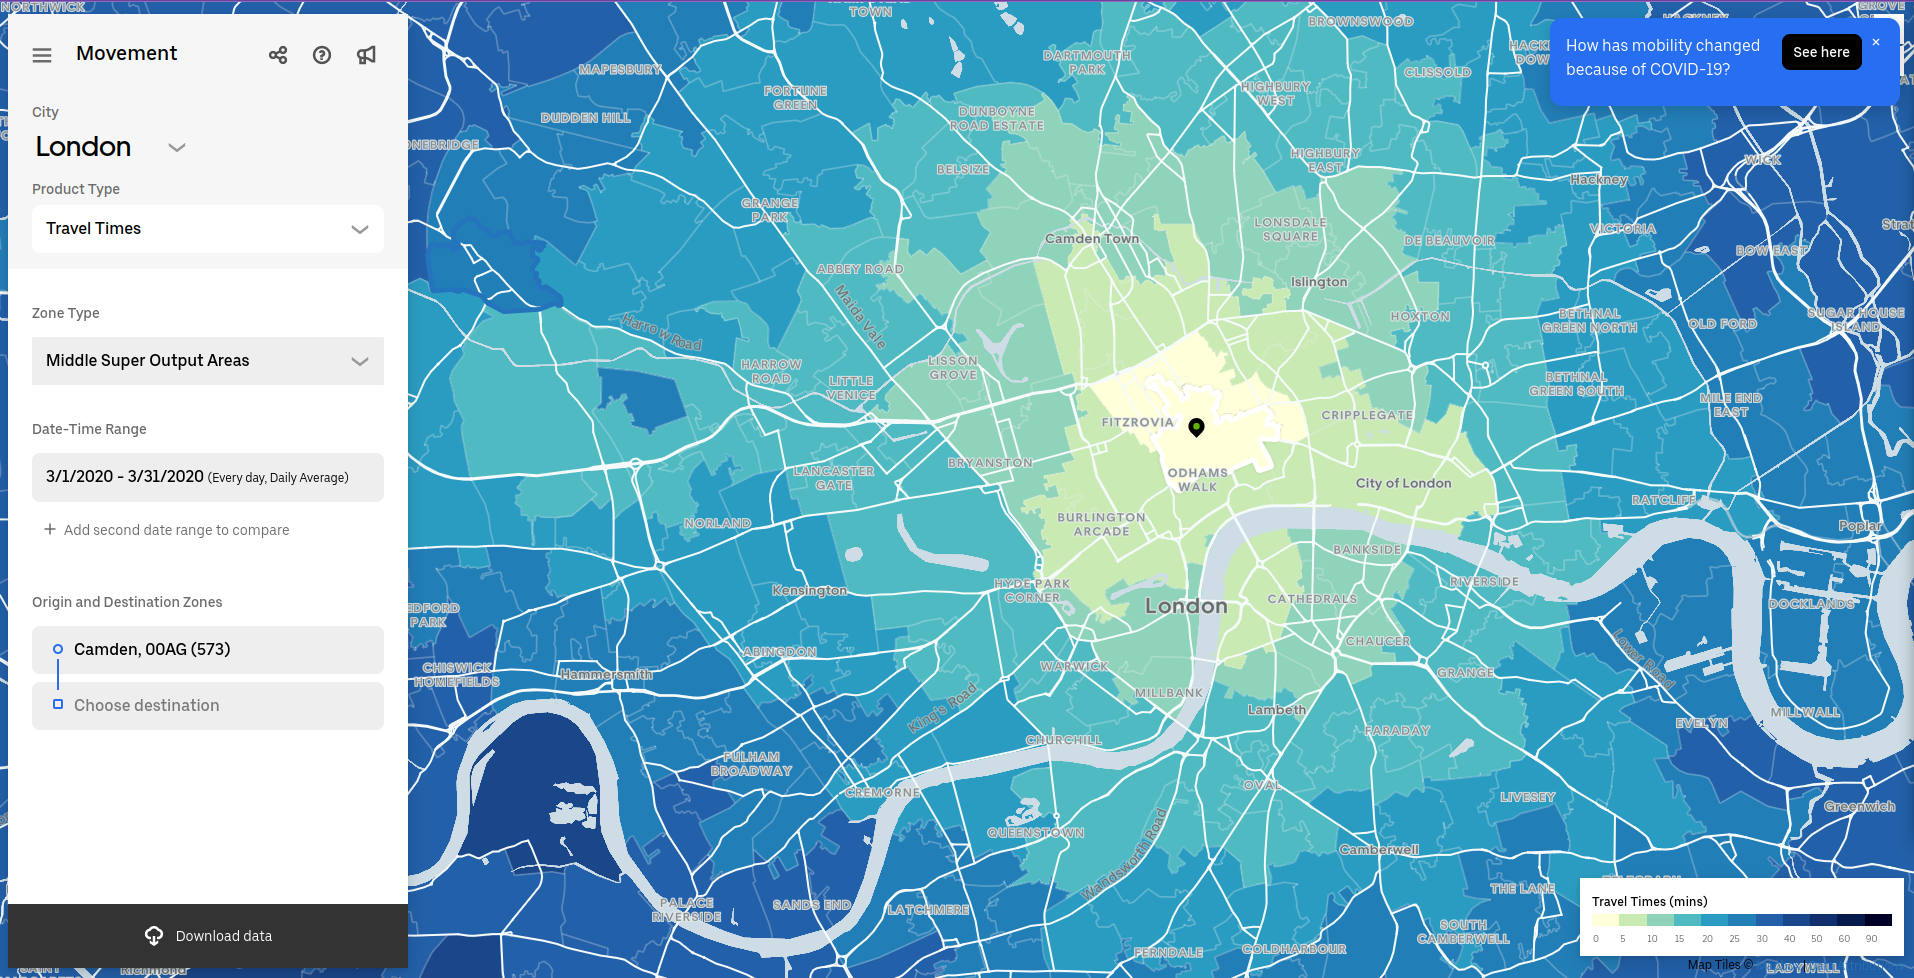

The menu on the left allows you to alterthe data by selecting date ranges, origins, and destinations. We can download the data using the "Download Data" button in the bottom-left.

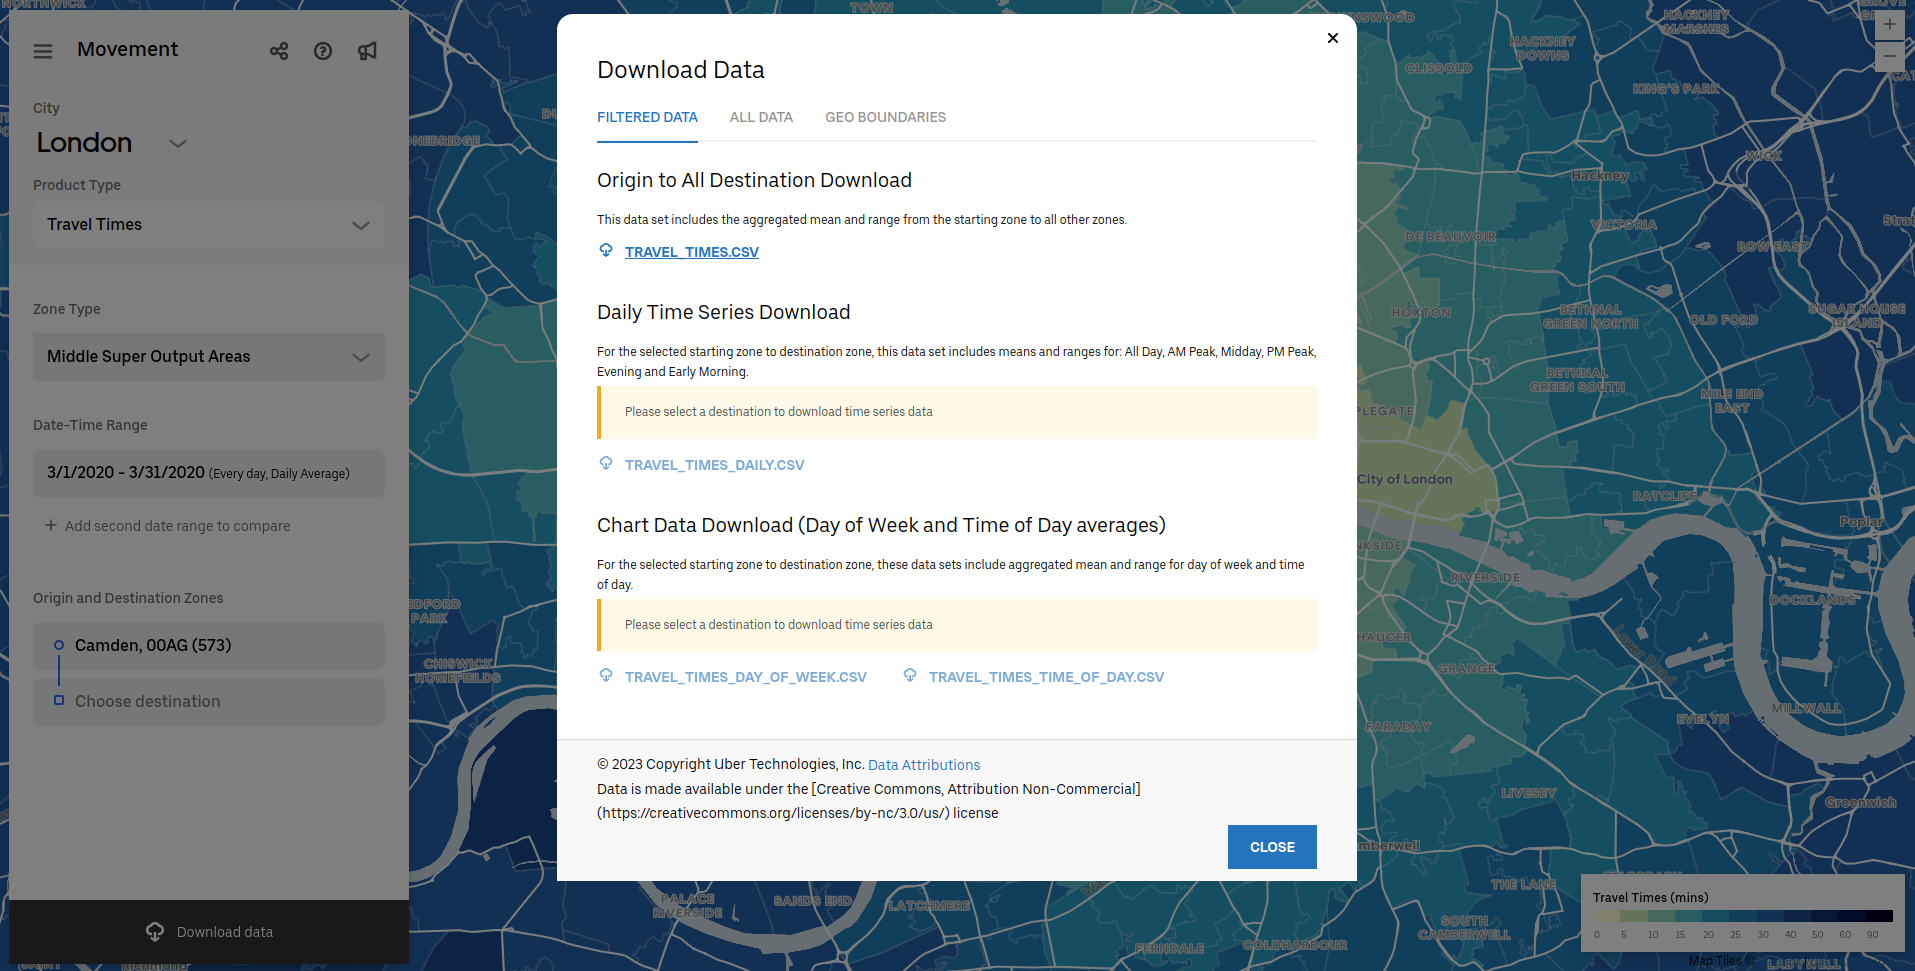

The Download Data screen provides a variety of options for filtered data, all data, and geo boundaries.

<p id="obtain-cli" />

## Command Line Interface (CLI)

The web interface is convenient for exploring and downloading data, but there is also a Commander Line Interface (CLI) available to use called [movement-data-toolkit](https://www.npmjs.com/package/movement-data-toolkit). 

Let's install the CLI:

In [3]:
!npm install -g movement-data-toolkit

npm WARN deprecated @oclif/screen@1.0.4: Deprecated in favor of @oclif/corem
npm WARN deprecated cli-ux@5.6.7: Package no longer supported. Contact Support at https://www.npmjs.com/support for more info.
npm WARN deprecated axios@0.18.1: Critical security vulnerability fixed in v0.21.1. For more information, see https://github.com/axios/axios/pull/3410
m##################⸩ ⠼ reify:lodash: timing reifyNode:node_modules/movement-datmov
changed 183 packages, and audited 184 packages in 6s

20 packages are looking for funding
  run `npm fund` for details

2 high severity vulnerabilities

To address all issues (including breaking changes), run:
  npm audit fix --force

Run `npm audit` for details.


In [4]:
# Let's check that the CLI installed:
# You should see the help text for the CLI print out.
!mdt --help

Tools and utilities for working with Uber Movement data

VERSION
  movement-data-toolkit/1.3.0 linux-x64 node-v17.1.0

USAGE
  $ mdt [COMMAND]

COMMANDS
  clear-cache           Some commands in this toolkit download files to a
                        temporary directory. These files can be rather large,
                        and it can be helpful to clear this data to reclaim disk
                        space.
  create-geometry-file  Creates a geojson file that contains the geometries for
                        each road segment in the specified city, as well as both
                        the corresponding OSM identifiers for each road segment.
  help                  display help for mdt
  speeds-to-geojson     Downloads and processes Movement speeds data into a
                        geojson file that can be visualized with Kepler.gl or
                        other geospatial visualization tools.
  speeds-transform      Downloads and transforms Movement Speeds data, filtering

Using this CLI, let's download the geometry for New York in 2020:

In [5]:
!mdt create-geometry-file new_york 2020 > data/newyork2020.geojson


create-geometry-file
Creates a geojson file that contains the geometries for each road segment in the specified city, as well as both the corresponding OSM identifiers for each road segment.
    
The produced file can help avoid the need to download and manipulate OSM geometries from the web yourself.
Data from OpenStreetMap–including road geometries or other OSM metadata and identifiers–is licensed under the Open Data Commons Open Database License (ODbL) by the OpenStreetMap Foundation (OSMF) (https://www.openstreetmap.org/copyright)


🗺  Road Geometries
    Reading geometries from input file...
🏗  Building output geojson...
🏗  Building output geojson... done
✅ Writing output...
✅ Writing output... done


Now, we can use the Geopandas package to load the file and plot it:

In [6]:
df = gpd.read_file("data/newyork2020.geojson")
df.head()

osmname  osmstartnodeid      osmhighway  osmendnodeid   osmwayid  \
0  147th Avenue        42856931        tertiary    5924962521  455778913   
1  147th Avenue      5924962521        tertiary      42856931  455778913   
2          None      3838008669  secondary_link    5212739096  380471663   
3          None      5212739096  secondary_link    3838008669  380471663   
4          None      5487813168  secondary_link    5212739096  604880067   

                                            geometry  
0  LINESTRING (-73.749 40.658, -73.748 40.658, -7...  
1  LINESTRING (-73.747 40.658, -73.747 40.658, -7...  
2        LINESTRING (-73.947 40.764, -73.947 40.764)  
3        LINESTRING (-73.947 40.764, -73.947 40.764)  
4        LINESTRING (-73.947 40.764, -73.947 40.764)

<AxesSubplot:>

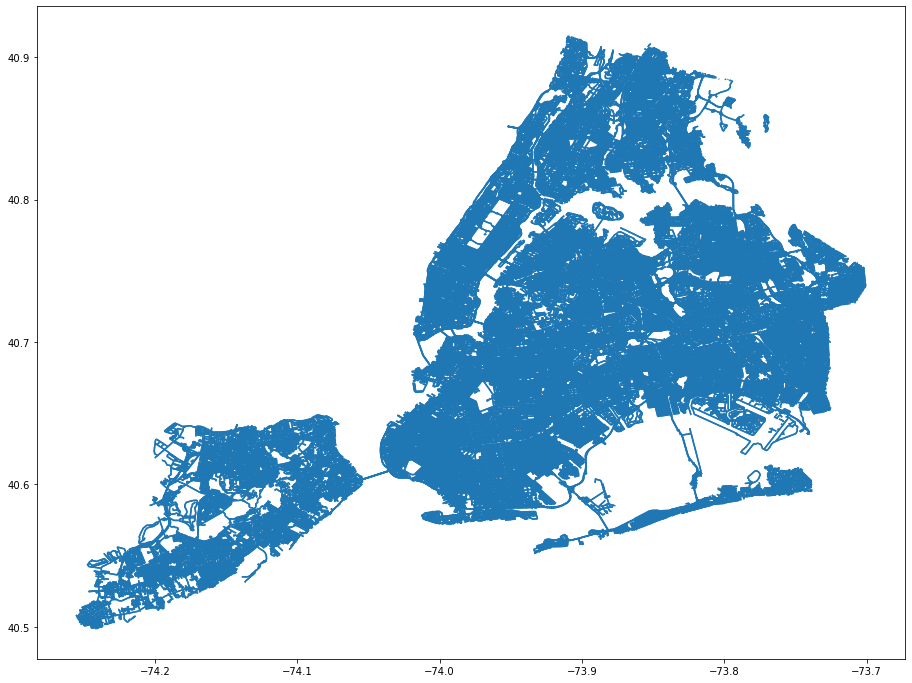

In [7]:
# This is a rather large file and will take a minute or so to plot
df.plot(figsize=FIGSIZE)

This is great, but the geometry of the road network can be obtained elsewhere. What we really want is the speed and travel time data. The MDT CLI can also be used to get the speed data over a given date range. 

The command below download the speeds in GeoJSON form New York city from November 1st, 2019 to November 2nd, 2019. 

**Note** that it takes >10 minutes to run, so we have provided the data already and the command is commented out, but you're welcome to run the command if you're willing to wait.

If you do run the command, you can [click here to skip over the very long output](#skip-mdt-download).

In [8]:
#!mdt speeds-to-geojson new_york 2019-11-01 2019-11-02 > data/nyspeed.geojson

<p id="skip-mdt-download" />

With our data downloaded, we can load and inspect it:

In [9]:
speed = gpd.read_file("data/nyspeed.geojson")
speed = speed.set_crs("EPSG:4326", allow_override=True)  # the CRS appears to be wrong if we don't manually set it
speed.head()

osmname  osmstartnodeid      osmhighway  osmendnodeid   osmwayid  \
0  147th Avenue        42856931        tertiary    5924962521  455778913   
1  147th Avenue      5924962521        tertiary      42856931  455778913   
2          None      3838008669  secondary_link    5212739096  380471663   
3          None      5212739096  secondary_link    3838008669  380471663   
4          None      5487813168  secondary_link    5212739096  604880067   

   speed_mean_mph  pct_from_freeflow  speed_freeflow_mph  \
0            22.0              -15.0                26.0   
1            22.0              -13.0                25.0   
2            19.0              -11.0                21.0   
3            15.0              -14.0                18.0   
4            14.0              -20.0                17.0   

                                            geometry  
0  LINESTRING (-73.74903 40.65762, -73.74849 40.6...  
1  LINESTRING (-73.74712 40.65751, -73.74729 40.6...  
2  LINESTRING (-73.94747 40.76396, -73.94744 40.7...  
3  LINESTRING (-73.94747 40.76402, -73.94750 40.7...  
4  LINESTRING (-73.94748 40.76408, -73.94747 40.7...

Let's plot the speed in miles per hour for each road segment:

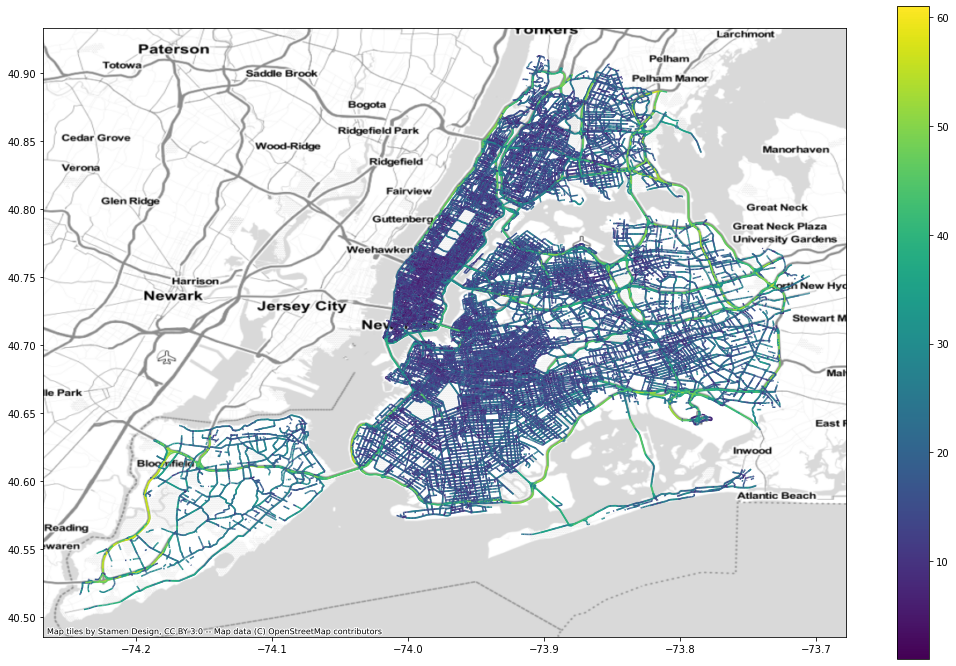

In [10]:
ax = speed.plot(column="speed_mean_mph", figsize=FIGSIZE, legend=True)
cx.add_basemap(ax, crs=speed.crs.to_string(), source=cx.providers.Stamen.TonerLite)

We can also plot the speed as a percentage of "free flow" which in this case means:
    
> Free-flow speed is the term used to describe the average speed of traffic in the absence of congestion or other adverse conditions (such as bad weather). We estimate the free-flow as the 85th percentile of all speed values observed on a segment during the earliest quarter into which your filtered time range falls. In the future, we’re hoping to refine this approach and develop a more accurate representation of free-flow speeds that our users can leverage.

 - [Uber Movement FAQ](https://movement.uber.com/faqs?lang=en-US)

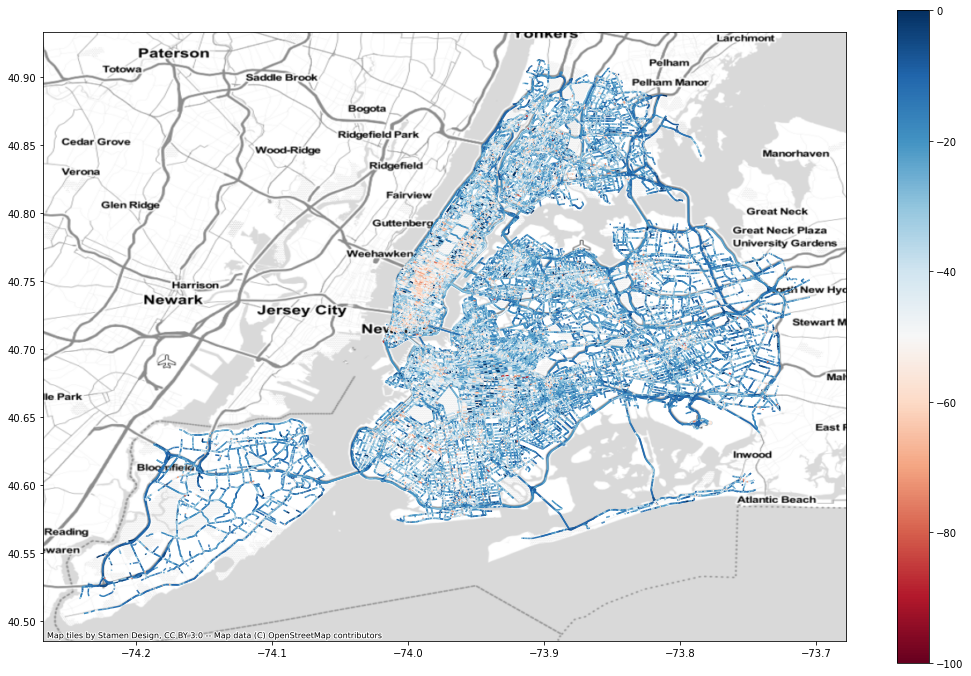

In [11]:
ax = speed.plot(column="pct_from_freeflow", figsize=FIGSIZE, cmap="RdBu", vmin=-100, vmax=0, legend=True)
cx.add_basemap(ax, crs=speed.crs.to_string(), source=cx.providers.Stamen.TonerLite)
plt.savefig("img/nyc-pct_from_freeflow.png")
plt.show()

We can theoretically create a networkx graph with the geoJSON that Uber Movements gives us, but we have run into issues in the past utilizing this graph for routing and network analysis. We have found that the better approach is to obtain our own road network from OpenStreetMap and attach the attributes we can to it.

In [12]:
# first, project to a non-geographic CRS like NAD83 for New York: https://epsg.io/32118
speed = speed.to_crs("EPSG:32118")
# then momepy can convert the geodataframe into a networkx graph
speednx = momepy.gdf_to_nx(speed)

In [13]:
type(speednx)

networkx.classes.multigraph.MultiGraph

<hr id="problem" />

# Uber Movement for Travel Time Calcuation

While the OSM data provided by Uber Movement is great for some purposes, it is problematic to be used for calculating travel time between two points. The figure below shows the geometry of OSM data provided by Uber. It has two edges for every road (highways on the left side), even if the road is one-way. It means that the geometry with the proper direction would have the correct travel speed data; however, the other direction of the geometry should not exist, and it would not have travel speed data, resulting in wrong free-flow traffic. 
<br><br>
Therefore, this notebook will walk you through how to retrieve OSM data from OSM planet and integrate Uber Movement data into the OSM road network, properly. 

![](./img/uber_osm_data_problem.jpg)

<hr id="osm" />

# Obtaining OpenStreetMap Data

While the Uber data is extremely useful, we also need OpenStreetMap network data (which the Uber data is based on) in network form to perform routing and network analysis. [Check out our notebook if you'd like to learn more about OpenStreetmap Network data and `osmnx`](https://cybergisxhub.cigi.illinois.edu/notebook/introduction-to-openstreetmap-osm-network-data/).

<p id="typical-osmnx" />

## Typical way using OSMnx

OSMnx provides the following functions to retrieves road network from Open Street Map. 
* Getting data from an address -> `graph_from_address`
* Getting data from a bounding box -> `graph_from_bbox`
* Getting data from a geocodable place -> `graph_from_place`
* Getting data around some point -> `graph_from_point`
* Getting data for some polygon -> `graph_from_polygon`

Among those five functions, we recommend to using either `graph_from_place` or `graph_from_polygon`. In this example, we demonstrate retrieving road networks using `graph_from_polygon` with Manhattan (New York County) geometry. 

Let's obtain the driving network for Manhattan. First, we will use the census API to get the geometry for Manhattan, then pull the data from OSMNX:

In [14]:
# Obtain Geomery of New York County (Manhattan) from Census API. 
def get_geography(geoid):
    # https://api.censusreporter.org/1.0/geo/tiger2016/16000US5367000?geom=true
    api_url = 'https://api.censusreporter.org/1.0/geo/latest/{0}?geom=true'
    data = requests.get(api_url.format(geoid)).json()
    # Get Features
    fdf = pd.DataFrame({
                        'Geoid': geoid,
                        'LandArea': data['properties']['aland'] / 2589988,
                        'Population': data['properties']['population']
                        }, index=[0])
    coords = data['geometry']['coordinates']
    if len(coords) > 1: # If county is divided into multiple discrete parts
        census_geom = MultiPolygon([Polygon(val[0]) for val in coords])
    else: # If county has one contiguous geometry
        census_geom = Polygon(coords[0])
    fdf['geometry'] = [census_geom]
    return gpd.GeoDataFrame(fdf, crs='epsg:4326', geometry = 'geometry')

# use our function to download the data and call the Geopandas `explore` function.
manhattan = get_geography('05000US36061')
manhattan.explore()

We can use this geometry to download the driving time network using the osmnx `graph_from_polygon` function:

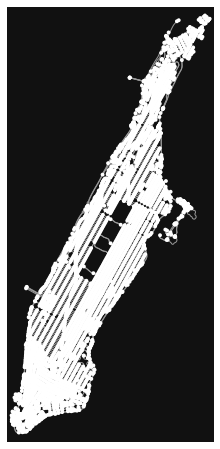

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [15]:
# Retrieve road network within the Manhattan polygon
G = ox.graph.graph_from_polygon(manhattan['geometry'][0], network_type='drive')
ox.plot_graph(G)

<p id="historical-osm" />

## Historical OSM data from OSM Planet

One critical limitation of OSMnx is that it does not support retrieving previous road networks. Given that Uber Movements data kept the OSM node and edge IDs at the time of travel, we should retrieve the road network closer to the date. 

### Data source
-- OSM Planet file <br>
https://planet.openstreetmap.org/  <br>
https://ftpmirror.your.org/pub/openstreetmap/  <br>

-- Applications needed (Both programs can be installed through homebrew) <br>
Osmosis: https://wiki.openstreetmap.org/wiki/Osmosis <br>
Osmfilter: https://wiki.openstreetmap.org/wiki/Osmfilter <br>

### Steps to Get Historical OSM Data ###

**Note:** These steps download a large amount of data and take a long time. They are not necessary for the rest of the notebook, but explain the necessary steps to obtain historical OSM data.

1. Obtain “planet-190107.osm.pbf”, replacing "190107" with the appropriate date you'd like to examine from https://ftpmirror.your.org/pub/openstreetmap/pbf/ or https://planet.openstreetmap.org/planet/full-history/
2. Run the following code in the terminal to clip the original world-wide `.osm.pbf file` to the given bounding box, which is around New York City. 
**Note**: `completeWays=yes` and `completeRelations=yes` are important to keep the relationship after the clipping. If these two queries aren’t included, `OSMnx.graph_from_xml` (https://osmnx.readthedocs.io/en/stable/osmnx.html#osmnx.graph.graph_from_xml) will return error.

``` 
osmosis \
    --read-pbf planet-190107.osm.pbf \
    --bounding-box top=40.917705 \
                   left=-74.358714 \
                   bottom=40.491167 \
                   right=-73.700169 \
                   completeWays=yes \
                   completeRelations=yes \
    --write-xml planet_190107_nyc.osm 
```

3. Query only the road network that car can travel. The criteria is as below based on the ones provided by OSMnx. 
4. Use `osmfilter` in the terminal to select edges with highway tag. <br>
    **Note**: `osmfilter` is used for this process since `osmosis` says `highway=*` is not found although its documentation says it is possible.  
    
```
osmfilter planet_190107_nyc.osm \
    --keep="highway=" \
    -o=nyc_190107_all_highways.osm 
```

5. After selecting every edge with highway tag, we want to remove edges with tags indicating cars cannot travel on their edges. Run the following code on the terminal. 

```
osmosis \
    --read-xml nyc_190107_all_highways.osm \
    --tf reject-ways highway=abandoned,bus_guideway,construction,corridor,cycleway,elevator,escalator,footway,path,pedestrian,planned,platform,proposed,raceway,service,steps \
    --tf reject-ways access=private \
    --tf reject-ways motor_vehicle=no \
    --tf reject-ways motorcar=no \
    --tf reject-ways service=alley,driveway,emergency_access,parking,parking_aisle,private\
    --tf reject-relations\
    --used-node \
    --write-xml  nyc_190107_cleaned.osm
```

6. RESULTED FILE (`*.osm`) can be imported to OSMnx with `ox.graph_from_xml()` function and then it can be exported to `*.graphml` file. 


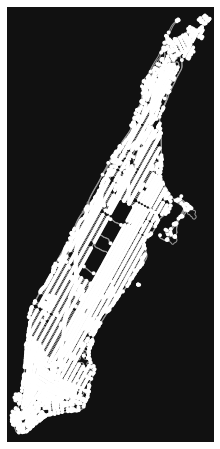

(<Figure size 576x576 with 1 Axes>, <AxesSubplot:>)

In [16]:
# Load Historical OSM network obtained from OSM Planet
G = ox.load_graphml('./data/manhattan_network.graphml')
ox.plot_graph(G)

<hr id="preprocessing" />

# Preprocessing Road Network 

This step preprocesses the road network from Open Street Map to make it ready to merge with Uber Movement data. Given that OSM is crowd-sourced datasets, it sometimes possesses issues preventing effective integration, such as disconnected networks and lack of speed limit information. 

First, we will define a function to remove nodes that you can't travel from:

In [17]:
def remove_unnecessary_nodes(network):
    """
    Removes nodes with no outdegree (nodes you cannot "leave").

    Args:
        network - networkx.classes.multidigraph.MultiDiGraph

    Returns:
        networkx.classes.multidigraph.MultiDiGraph - network with nodes removed.
    """
    _nodes_removed = len([n for (n, deg) in network.out_degree() if deg == 0])
    network.remove_nodes_from([n for (n, deg) in network.out_degree() if deg == 0])
    for component in list(nx.strongly_connected_components(network)):
        if len(component) < 100:
            for node in component:
                _nodes_removed += 1
                network.remove_node(node)

    print("Removed {} nodes ({:2.4f}%) from the OSMNX network".format(_nodes_removed, _nodes_removed / float(
        network.number_of_nodes())))
    print("Number of nodes: {}".format(network.number_of_nodes()))
    print("Number of edges: {}".format(network.number_of_edges()))

    return network

Next, we will remove any edges of the graph that do not support road travel:

In [18]:
def remove_unnecessary_edges(network, road_types):
    """
    Remove edges that car cannot travel; retrieved based on 'highway' attribute

    Args:
        network - networkx.classes.multidigraph.MultiDiGraph
        road_types - List[str], way types to remove

    Returns:
        networkx.classes.multidigraph.MultiDiGraph - network with ways removed.
    """
    _edges_removed = 0
    for u, v, data in network.copy().edges(data=True):
        if 'highway' in data.keys():
            if type(data['highway']) == list:
                highway_type = data['highway'][0]
            else:
                highway_type = data['highway']
            if highway_type in road_types:  # Car cannot travel on these types of road
                network.remove_edge(u, v)
                _edges_removed += 1
    print("Removed {} edges ({:2.4f}%) from the OSMNX network".format(_edges_removed, _edges_removed /
                                                                      float(network.number_of_edges())))
    return network

Now, we can apply these two functions to our road network:

In [19]:
# Remove disconnected network and unnecessary road types (e.g., bridleway)
G = remove_unnecessary_edges(G, ['bridleway', 'access'])
G = remove_unnecessary_nodes(G)

Removed 0 edges (0.0000%) from the OSMNX network
Removed 88 nodes (0.0192%) from the OSMNX network
Number of nodes: 4588
Number of edges: 10230


Now, we want to assign the usual maximum speeds to roads where we do not have information based on the type of the roadway:

In [20]:
def assign_max_speed_with_highway_type(network):
    """
    Assigns the speed limit to each way based on the way type. Maxspeed here was obtained from the mode
    of `maxspeed` attribute per `highway` type.
    
    Args:
        network - networkx.classes.multidigraph.MultiDiGraph
    
    Returns:
        networkx.classes.multidigraph.MultiDiGraph, with speed limits added
    """
    max_speed_per_type = {'motorway': 50,
                          'motorway_link': 30,
                          'trunk': 35,
                          'trunk_link': 25,
                          'primary': 25,
                          'primary_link': 25,
                          'secondary': 25,
                          'secondary_link': 25,
                          'tertiary': 25,
                          'tertiary_link': 25,
                          'residential': 25,
                          'living_street': 25,
                          'unclassified': 25,
                          'road': 25,
                          'track': 25
                          }
    for u, v, data in network.edges(data=True):
        # Assign the maximum speed of edges based on either 'maxspeed' or 'highway' attributes
        if 'maxspeed' in data.keys():
            if type(data['maxspeed']) == list:
                temp_speed = data['maxspeed'][0]  # extract only the first entry if there are many
            else:
                temp_speed = data['maxspeed']

            if type(temp_speed) == str:
                temp_speed = temp_speed.split(' ')[0]  # Extract only the number
                temp_speed = int(temp_speed)
        else:
            if 'highway' in data.keys():
                # if the variable is a list, grab just the first one.
                if type(data['highway']) == list:
                    road_type = data['highway'][0]
                else:
                    road_type = data['highway']
                # If the maximum speed of the road_type is predefined.
                if road_type in max_speed_per_type.keys():
                    temp_speed = max_speed_per_type[road_type]
                else:  # If not defined, just use 20 mph.
                    temp_speed = 20
            else:
                temp_speed = 20
        data['maxspeed'] = temp_speed  # Assign back to the original entry
    return network

In [21]:
# Apply the function
G = assign_max_speed_with_highway_type(G)

Converting our network back to a GeoDataFrame can be easily achieved using the osmnx `graph_to_gdfs` function.

In [22]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)
edges.head()

osmid  oneway              name      highway  \
u          v          key                                                     
1773060097 42437559   0      5670536    True  Catherine Street  residential   
           1773060099 0    165775306    True    Chatham Square      primary   
42459137   596776089  0      5673456   False  East 79th Street    secondary   
           42438490   0     46240204    True       Park Avenue    secondary   
           42447105   0      5673456   False  East 79th Street    secondary   

                           maxspeed   length  \
u          v          key                      
1773060097 42437559   0          25   11.237   
           1773060099 0          25   51.557   
42459137   596776089  0          25   23.132   
           42438490   0          25   87.390   
           42447105   0          25  142.034   

                                                                    geometry  \
u          v          key                                                      
1773060097 42437559   0    LINESTRING (-73.99759 40.71406, -73.99749 40.7...   
           1773060099 0    LINESTRING (-73.99759 40.71406, -73.99763 40.7...   
42459137   596776089  0    LINESTRING (-73.96038 40.77557, -73.96062 40.7...   
           42438490   0    LINESTRING (-73.96038 40.77557, -73.95988 40.7...   
           42447105   0    LINESTRING (-73.96038 40.77557, -73.95921 40.7...   

                          lanes  ref tunnel junction bridge width access  
u          v          key                                                 
1773060097 42437559   0     NaN  NaN    NaN      NaN    NaN   NaN    NaN  
           1773060099 0     NaN  NaN    NaN      NaN    NaN   NaN    NaN  
42459137   596776089  0     NaN  NaN    NaN      NaN    NaN   NaN    NaN  
           42438490   0       3  NaN    NaN      NaN    NaN   NaN    NaN  
           42447105   0     NaN  NaN    NaN      NaN    NaN   NaN    NaN

<hr id="using" />

# Using Uber Movement Data

<p id="approach-1" />

## Approach 1: Match based on the `start` and `end` node IDs 

Uber movements data provides each hour's time-dependent travel speed as average (`speed_mph_mean`) and standard deviation (`speed_mph_stddev`). Each hour record has `osm_way_id`, `osm_start_node_id`, and `osm_end_node_id`. <br>
In this step, we match the uber movement data with OSM based on the start and end node IDs. 

The sample data (`uber_df`) has the traffic speed of roads in Manhattan, New York City, for 12 o'clock between May 6, 2019 and May 10, 2019. 

In [23]:
uber_df = pd.read_csv('./data/uber_may_second_week_noon.csv')
uber_df.head(3)

Unnamed: 0  year  month  day  hour             utc_timestamp  \
0           0  2019      5   10    12  2019-05-10T16:00:00.000Z   
1           1  2019      5    8    12  2019-05-08T16:00:00.000Z   
2           2  2019      5    6    12  2019-05-06T16:00:00.000Z   

                                 segment_id  \
0  21de037d73347b2020bc58dbe1ea1deeaabb6f63   
1  21de037d73347b2020bc58dbe1ea1deeaabb6f63   
2  21de037d73347b2020bc58dbe1ea1deeaabb6f63   

                          start_junction_id  \
0  b7e9e3a195bf869664bb03e067ec2e256d57bc70   
1  b7e9e3a195bf869664bb03e067ec2e256d57bc70   
2  b7e9e3a195bf869664bb03e067ec2e256d57bc70   

                            end_junction_id  osm_way_id  osm_start_node_id  \
0  e612e6c5a44a5ef3c4c1ee73f74100450ae45375   380471663         2300353500   
1  e612e6c5a44a5ef3c4c1ee73f74100450ae45375   380471663         2300353500   
2  e612e6c5a44a5ef3c4c1ee73f74100450ae45375   380471663         2300353500   

   osm_end_node_id  speed_mph_mean  speed_mph_stddev  
0       5212739096          12.736             2.454  
1       5212739096          14.425             3.135  
2       5212739096          15.666             2.148

In [24]:
def calculate_weighted_mean(means, stds):
    """
    Calculates the inverse-standard deviation weighted mean.
    
    Args:
        means - List[float], the means
        stds - List[float], the standard deviations
    
    Returns:
        the inverse-standard deviation weighted mean
    """
    return sum(means * 1 / stds) / sum(1 / stds)

In [25]:
def join_uber_data_with_osm_edges_(network, uber_hour_df):
    """
    Assigns the inverse-standard deviation weighted mean of uber speeds to the network for matching ways.
    
    Args:
        network - networkx.classes.multidigraph.MultiDiGraph
        uber_hour_df - pandas.DataFrame of ways
    
    Returns:
        networkx.classes.multidigraph.MultiDiGraph with weighted mean travel-time added.
    """
    for u, v, data in tqdm(network.edges(data=True)):
        # When travel time records in uber dataset match with OSM based on origin (u) and destination (v),
        # we update `uber_speed` of network (G) based on the uber records.
        match_ori_dest = uber_hour_df.loc[(uber_hour_df['osm_start_node_id'] == u) &
                                          (uber_hour_df['osm_end_node_id'] == v)
                                          ]
        
        # If there are matching records,
        # we average the travel time of Uber with the inverse weights of standard deviation.
        # Higher standard deviation has less weight
        if match_ori_dest.shape[0] > 0:
            weighted_mean = calculate_weighted_mean(match_ori_dest['speed_mph_mean'].values,
                                                    match_ori_dest['speed_mph_stddev'].values
                                                    )
            data['uber_speed'] = weighted_mean

        # If there is no matching records based on the origin (u) and destination (v),
        # we just skip the corresponding row for now. 
        else:
            pass
    return network

Run the above function to add the speed data:

In [26]:
G_ = join_uber_data_with_osm_edges_(G, uber_df)

100%|██████████| 10230/10230 [00:10<00:00, 1012.46it/s]


Now, we can export the graph data to a GeoDataFrame for easy statistics, inspection, and visualization. We will also calculate `speed_ratio` as the ratio between the uber speed and the maximum speed limit on the road segment:

In [27]:
# Export NetworkX to GeoDataFrame for Visualization
nodes_, edges_ = ox.graph_to_gdfs(G_, nodes=True, edges=True, node_geometry=True)

# Calculate the ratio of edges that don't have travel speed provided by Uber Movement. 
ratio_ = edges_.loc[~edges_['uber_speed'].isna()].shape[0] / edges_.shape[0]
print(f"{round(ratio_, 3) * 100}% of edges have recorded travel speed.")
edges_['speed_ratio'] = edges_.apply(lambda x:x['uber_speed'] / x['maxspeed'], axis=1)
edges_.head()

52.7% of edges have recorded travel speed.


osmid  oneway              name      highway  \
u          v          key                                                     
1773060097 42437559   0      5670536    True  Catherine Street  residential   
           1773060099 0    165775306    True    Chatham Square      primary   
42459137   596776089  0      5673456   False  East 79th Street    secondary   
           42438490   0     46240204    True       Park Avenue    secondary   
           42447105   0      5673456   False  East 79th Street    secondary   

                           maxspeed   length  \
u          v          key                      
1773060097 42437559   0          25   11.237   
           1773060099 0          25   51.557   
42459137   596776089  0          25   23.132   
           42438490   0          25   87.390   
           42447105   0          25  142.034   

                                                                    geometry  \
u          v          key                                                      
1773060097 42437559   0    LINESTRING (-73.99759 40.71406, -73.99749 40.7...   
           1773060099 0    LINESTRING (-73.99759 40.71406, -73.99763 40.7...   
42459137   596776089  0    LINESTRING (-73.96038 40.77557, -73.96062 40.7...   
           42438490   0    LINESTRING (-73.96038 40.77557, -73.95988 40.7...   
           42447105   0    LINESTRING (-73.96038 40.77557, -73.95921 40.7...   

                           uber_speed lanes  ref tunnel junction bridge width  \
u          v          key                                                       
1773060097 42437559   0           NaN   NaN  NaN    NaN      NaN    NaN   NaN   
           1773060099 0      8.250923   NaN  NaN    NaN      NaN    NaN   NaN   
42459137   596776089  0      8.375999   NaN  NaN    NaN      NaN    NaN   NaN   
           42438490   0     13.947668     3  NaN    NaN      NaN    NaN   NaN   
           42447105   0      3.727590   NaN  NaN    NaN      NaN    NaN   NaN   

                          access  speed_ratio  
u          v          key                      
1773060097 42437559   0      NaN          NaN  
           1773060099 0      NaN     0.330037  
42459137   596776089  0      NaN     0.335040  
           42438490   0      NaN     0.557907  
           42447105   0      NaN     0.149104

Let's plot the Uber speed data (left) and the speed as a function of the maximum speed for each road segment:

<AxesSubplot:>

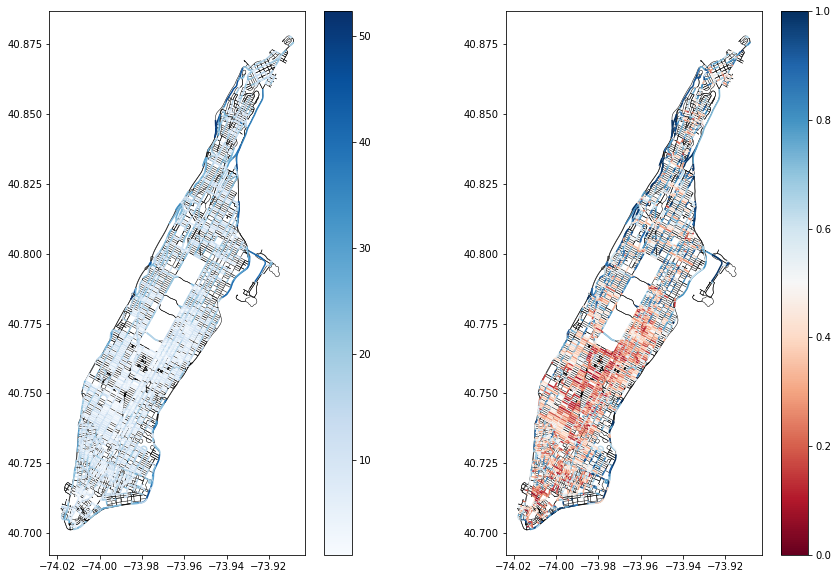

In [28]:
fig, axes = plt.subplots(1,2, figsize=(15, 10))

edges_.loc[edges_['uber_speed'].isna()].plot(color='black', ax=axes[0], linewidth=0.5)
edges_.plot('uber_speed', ax=axes[0], cmap='Blues', legend=True)
edges_.loc[edges_['uber_speed'].isna()].plot(color='black', ax=axes[1], linewidth=0.5)
edges_.plot('speed_ratio', ax=axes[1], cmap='RdBu', vmin=0 , vmax=1 ,legend=True)

<p id="approach-2" />

## Approach 2: Match with Edge ID and Azimuth of edges

Given that the matching rate with start and end nodes IDs was not successful, we here try to bring OSM ids for edges. But, in the meantime, we also should be cautious about matching the wrong travel speed with the wrong edges. Therefore, I integrated a step for checking the azimuth of edges, comparing it with the osm dataset provided by Uber. <br>

**This step assumes a case that the edge IDs remain the same, but node IDs have updated.**

In [29]:
# Import OSM data provided by Uber
uber_osm = gpd.read_file('./data/newyork2020.geojson')
uber_osm = uber_osm.set_crs(epsg=4326, allow_override=True)

Let's investigate the road network (OSM) geometry retrieved from OSM Planet and Uber Movement. <br>
The two maps at the bottom describe the geometry of the same road. But OSM Planet data has it as a single geometry, while Uber Movement/OSM has two lines, indicating both directions. <br>

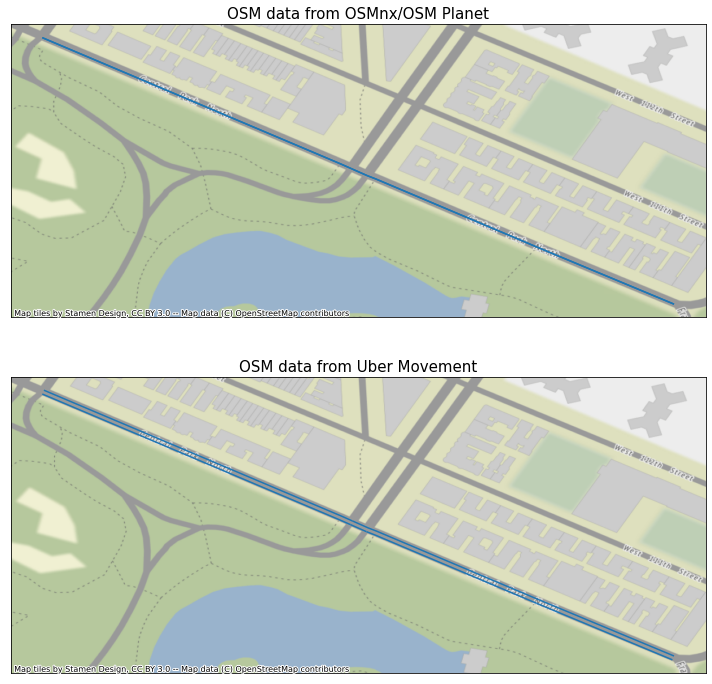

In [30]:
fig, axes = plt.subplots(2, 1, figsize=(10, 10))

edges.loc[edges['osmid'] == 44164416].plot(ax=axes[0])
cx.add_basemap(axes[0], crs=uber_osm.crs.to_string())
axes[0].set_title('OSM data from OSMnx/OSM Planet', fontsize=15)

uber_osm.loc[uber_osm['osmwayid'] == 44164416].plot(ax=axes[1])
cx.add_basemap(axes[1], crs=uber_osm.crs.to_string())
axes[1].set_title('OSM data from Uber Movement', fontsize=15)

axes[0].get_xaxis().set_visible(False)
axes[0].get_yaxis().set_visible(False)
axes[1].get_xaxis().set_visible(False)
axes[1].get_yaxis().set_visible(False)

fig.tight_layout()

In [31]:
def calculate_azimuth(x1, y1, x2, y2):
    # Calculate the azimuth between two points
    d_x = x2 - x1  # Delta of x coordinates
    d_y = y2 - y1  # Delta of y coordinates
    temp_azimuth = math.degrees(math.atan2(d_x, d_y)) # Calculate Azimuth from the ArcTangent of two delta values. 
    if temp_azimuth > 0:
        return temp_azimuth
    else:
        return temp_azimuth + 360

In [32]:
def assign_speed_based_on_azimuth(network, u, v, match_df, uber_osm_edges):
    # The azimuth of current edges in the loop
    current_azimuth = round(calculate_azimuth(network.nodes[u]['x'], network.nodes[u]['y'],
                                              network.nodes[v]['x'], network.nodes[v]['y']), -1)
    match_df = match_df.merge(uber_osm_edges,
                              left_on=['osm_start_node_id', 'osm_end_node_id'],
                              right_on=['osmstartnodeid', 'osmendnodeid']
                              )
    if match_df.shape[0] > 0:
        match_df['azimuth'] = match_df.apply(lambda x: round(calculate_azimuth(x.geometry.coords[:][0][0],
                                                                               x.geometry.coords[:][0][1],
                                                                               x.geometry.coords[:][-1][0],
                                                                               x.geometry.coords[:][-1][1]), 
                                                             -1),
                                             axis=1)
        # Consider two edges are the same, 
        # if the azimuth of the current edges are within += 10 degree compared to the uber osm data.
        edges_of_interest = match_df.loc[match_df['azimuth'].isin([i + current_azimuth for i in range(-30, 40, 10)])]
        if edges_of_interest.shape[0] > 0:
            return calculate_weighted_mean(edges_of_interest['speed_mph_mean'], edges_of_interest['speed_mph_stddev'])
        else:
            return np.nan
    else:
        return np.nan

In [33]:
def join_uber_data_with_osm_edges(network, uber_hour_df, uber_osm_gdf):
    # Tries to match the Uber and OSM data using IDs and azimuth
    for u, v, data in tqdm(network.edges(data=True)):
        # When travel time records in uber dataset match with OSM based on origin (u) and destination (v),
        # we update `uber_speed` of network (G) based on the uber records.
        match_ori_dest = uber_hour_df.loc[(uber_hour_df['osm_start_node_id'] == u) &
                                          (uber_hour_df['osm_end_node_id'] == v)]
        # If there are matching records,
        # we average the travel time of Uber with the inverse weights of standard deviation.
        # Higher standard deviation has less weight
        if match_ori_dest.shape[0] > 0:
            weighted_mean = calculate_weighted_mean(match_ori_dest['speed_mph_mean'].values,
                                                    match_ori_dest['speed_mph_stddev'].values)
            data['uber_speed'] = weighted_mean
        # If there is no matching records based on the origin (u) and destination (v),
        # we now try to match with their osm_way_id.
        # Given the osm_way_id is assigned based on the road names (i.e., multiple edges per osm_way_id),
        # we need to match the direction of edges (based on azimuth of edges) to retrieve travel time properly.
        else:
            if type(data['osmid']) == int:
                match_osmid = uber_hour_df.loc[uber_hour_df['osm_way_id'] == data['osmid']]
                if match_osmid.shape[0] > 0:
                    weighted_mean = assign_speed_based_on_azimuth(network, u, v, match_osmid, uber_osm_gdf)
                    data['uber_speed'] = weighted_mean
            elif type(data['osmid']) == list:
                speed_list = []
                for temp_id in data['osmid']:
                    match_osmid = uber_hour_df.loc[uber_hour_df['osm_way_id'] == temp_id]

                    if match_osmid.shape[0] > 0:
                        weighted_mean = assign_speed_based_on_azimuth(network, u, v, match_osmid, uber_osm_gdf)
                        speed_list.append(weighted_mean)
                if speed_list:
                    data['uber_speed'] = sum(speed_list) / len(speed_list)
    return network

In [34]:
G = join_uber_data_with_osm_edges(G, uber_df, uber_osm)

100%|██████████| 10230/10230 [03:59<00:00, 42.80it/s]


With the data matched, we can export NetworkX to GeoDataFrame for Visualization:

In [35]:
nodes, edges = ox.graph_to_gdfs(G, nodes=True, edges=True, node_geometry=True)

# Calculate the ratio of edges that don't have travel speed provided by Uber Movement. 
ratio = edges.loc[~edges['uber_speed'].isna()].shape[0] / edges_.shape[0]
print(f"{round(ratio, 3) * 100}% of edges have recorded travel speed.")
edges['speed_ratio'] = edges.apply(lambda x:x['uber_speed'] / x['maxspeed'], axis=1)
edges.loc[edges['osmid'] == 44164416].sort_values(by='length')

73.6% of edges have recorded travel speed.


osmid  oneway                name    highway  \
u          v          key                                                    
42426374   3099327964 0    44164416   False  Central Park North  secondary   
3099327964 42426374   0    44164416   False  Central Park North  secondary   
42426374   595703226  0    44164416   False  Central Park North  secondary   
595703226  42426374   0    44164416   False  Central Park North  secondary   
2141026499 3099327964 0    44164416   False  Central Park North  secondary   
3099327964 2141026499 0    44164416   False  Central Park North  secondary   

                           maxspeed   length  \
u          v          key                      
42426374   3099327964 0          25   13.270   
3099327964 42426374   0          25   13.270   
42426374   595703226  0          25  255.623   
595703226  42426374   0          25  255.623   
2141026499 3099327964 0          25  258.323   
3099327964 2141026499 0          25  258.323   

                                                                    geometry  \
u          v          key                                                      
42426374   3099327964 0    LINESTRING (-73.95239 40.79821, -73.95253 40.7...   
3099327964 42426374   0    LINESTRING (-73.95253 40.79827, -73.95239 40.7...   
42426374   595703226  0    LINESTRING (-73.95239 40.79821, -73.95232 40.7...   
595703226  42426374   0    LINESTRING (-73.94974 40.79710, -73.95092 40.7...   
2141026499 3099327964 0    LINESTRING (-73.95521 40.79941, -73.95262 40.7...   
3099327964 2141026499 0    LINESTRING (-73.95253 40.79827, -73.95262 40.7...   

                           uber_speed lanes  ref tunnel junction bridge width  \
u          v          key                                                       
42426374   3099327964 0     14.089000   NaN  NaN    NaN      NaN    NaN   NaN   
3099327964 42426374   0     14.839172   NaN  NaN    NaN      NaN    NaN   NaN   
42426374   595703226  0     11.637918   NaN  NaN    NaN      NaN    NaN   NaN   
595703226  42426374   0     13.855076   NaN  NaN    NaN      NaN    NaN   NaN   
2141026499 3099327964 0      8.136108   NaN  NaN    NaN      NaN    NaN   NaN   
3099327964 2141026499 0     13.610000   NaN  NaN    NaN      NaN    NaN   NaN   

                          access  speed_ratio  
u          v          key                      
42426374   3099327964 0      NaN     0.563560  
3099327964 42426374   0      NaN     0.593567  
42426374   595703226  0      NaN     0.465517  
595703226  42426374   0      NaN     0.554203  
2141026499 3099327964 0      NaN     0.325444  
3099327964 2141026499 0      NaN     0.544400

<AxesSubplot:>

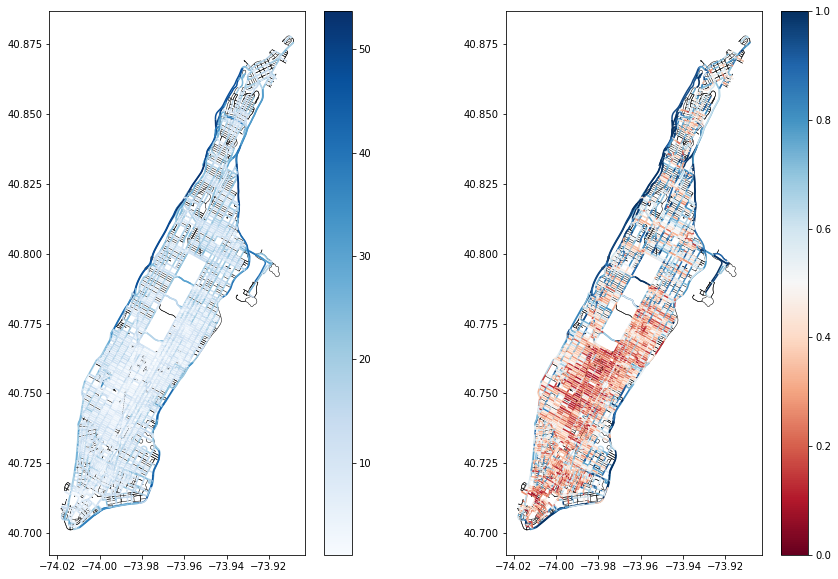

In [36]:
fig, axes = plt.subplots(1,2, figsize=(15, 10))

edges.loc[edges['uber_speed'].isna()].plot(color='black', ax=axes[0], linewidth=0.5)
edges.plot('uber_speed', ax=axes[0], cmap='Blues', legend=True)
edges.loc[edges['uber_speed'].isna()].plot(color='black', ax=axes[1], linewidth=0.5)
edges.plot('speed_ratio', ax=axes[1], cmap='RdBu', vmin=0 , vmax=1 ,legend=True)

<hr id="ref" />

# Learn More / References

## Blogs and Informal Resources

* ["movement-data-toolkit"](https://www.npmjs.com/package/movement-data-toolkit)
* ["Working with Uber Movement Speeds data" by David Schnurr on Medium](https://medium.com/uber-movement/working-with-uber-movement-speeds-data-cc01d35937b3)


## Academic Papers

* Boeing, Geoff. "OSMnx: New methods for acquiring, constructing, analyzing, and visualizing complex street networks" https://doi.org/10.1016/j.compenvurbsys.2017.05.004